<a href="https://colab.research.google.com/github/hamednasr/deep-learning/blob/main/my_code_chal_how_wide_is_FC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [75]:
torch.cuda.is_available()

True

In [76]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
device

# Create Gaussian blurs with different widths

In [77]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

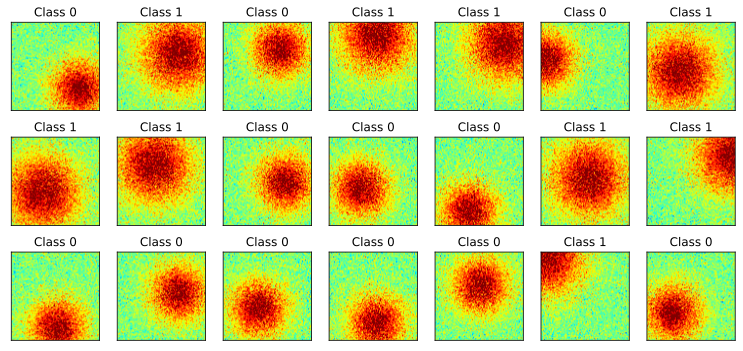

In [78]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [79]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [80]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


# Create the DL model

In [81]:
# create a class for the model
units=5
def makeTheNet(units):

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45 
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          nn.Flatten(),                # vectorize conv output

          nn.Linear(22*22*4,2*units),       # output size: 2*units
          nn.Linear(2*units,units),         # output size: units
          nn.Linear(units,1),             # output size: 1
      )
      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [82]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(units)
net.to(device)
X,y = iter(train_loader).next()
X = X.to(device)
y = y.to(device)
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([32, 1])
 
Loss:
tensor(0.6904, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [83]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 10]          19,370
            Linear-9                    [-1, 5]              55
           Linear-10                    [-1, 1]               6
Total params: 19,711
Trainable params: 19,711
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.08
Estimated Tot

# Create a function that trains the model

In [84]:
# a function that trains the model

def function2trainTheModel(units):

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet(units)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  net.to(device)   #sending the net to GPU

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:
      
      X = X.to(device)   #sending X to GPU
      y = y.to(device)   #sending y to GPU


      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    X = X.to(device)   #sending X to GPU
    y = y.to(device)   #sending y to GPU

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model and show the results!

In [85]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel(5)

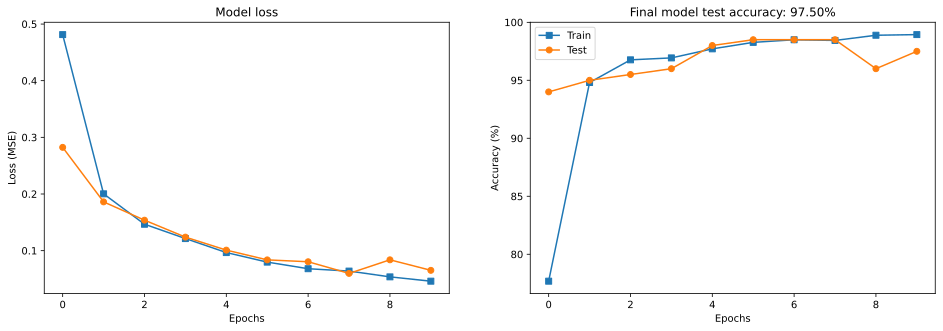

In [86]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [88]:
# look at the filters
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=10, bias=True)
    (8): Linear(in_features=10, out_features=5, bias=True)
    (9): Linear(in_features=5, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


In [89]:
unitset = np.linspace(5,500,12)
results = np.zeros((12,4))

for i, units in enumerate(unitset):

  trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel(int(units))
  results[i,0] = torch.mean(trainLoss[-3:])
  results[i,1] = torch.mean(testLoss[-3:])
  results[i,2] = torch.mean(trainAcc[-3:])
  results[i,3] = torch.mean(testAcc[-3:])

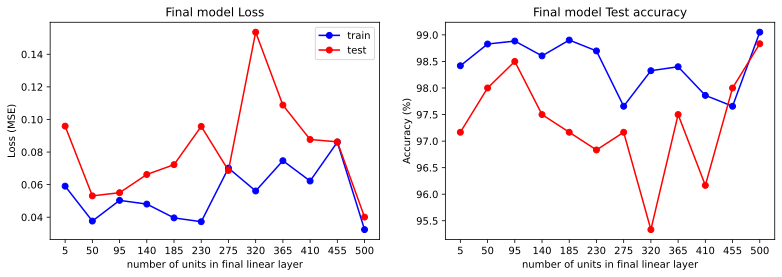

In [90]:

fig, ax = plt.subplots(1,2,figsize=(13,4))
ax[0].plot(unitset,results[:,0],'bo-',label = 'train')
ax[0].plot(unitset,results[:,1],'ro-',label = 'test')
ax[0].set_title('Final model Loss')
ax[0].set_xticks(unitset)
ax[0].set_xlabel('number of units in final linear layer')
ax[0].set_ylabel('Loss (MSE)')
ax[0].legend()

ax[1].plot(unitset,results[:,2],'bo-',label ='train')
ax[1].plot(unitset,results[:,3],'ro-',label ='test')
ax[1].set_title('Final model Test accuracy')
ax[1].set_xticks(unitset)
ax[1].set_xlabel('number of units in final linear layer')
ax[1].set_ylabel('Accuracy (%)')
ax[0].legend()

plt.show()